<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Columns: 382 entries, Power_1 to Total Distance(m)
dtypes: float64(305), int64(77)
memory usage: 52.5 MB
None
    Power_1   Power_2   Power_3   Power_4   Power_5   Power_6   Power_7  \
0  0.000000  0.000000  0.000007  0.000007  0.000007  0.000000  0.000007   
1  0.000000  0.000007  0.000000  0.000007  0.000000  0.000007  0.000000   
2  0.000000  0.000000  0.000000  0.000007  0.000000  0.000000  0.000000   
3  0.000007  0.000007  0.000007  0.000007  0.000007  0.000000  0.000000   
4  0.000000  0.000000  0.000007  0.000000  0.000007  0.000000  0.000000   

   Power_8   Power_9  Power_10  ...    GSNR_69    GSNR_70    GSNR_71  \
0      0.0  0.000007       0.0  ...  90.061284   0.000000   0.000000   
1      0.0  0.000000       0.0  ...   0.000000  92.560867   0.000000   
2      0.0  0.000007       0.0  ...   0.000000   0.000000  90.991977   
3      0.0  0.000007       0.0  ...  76.409583  73.664915  74.651700   
4  

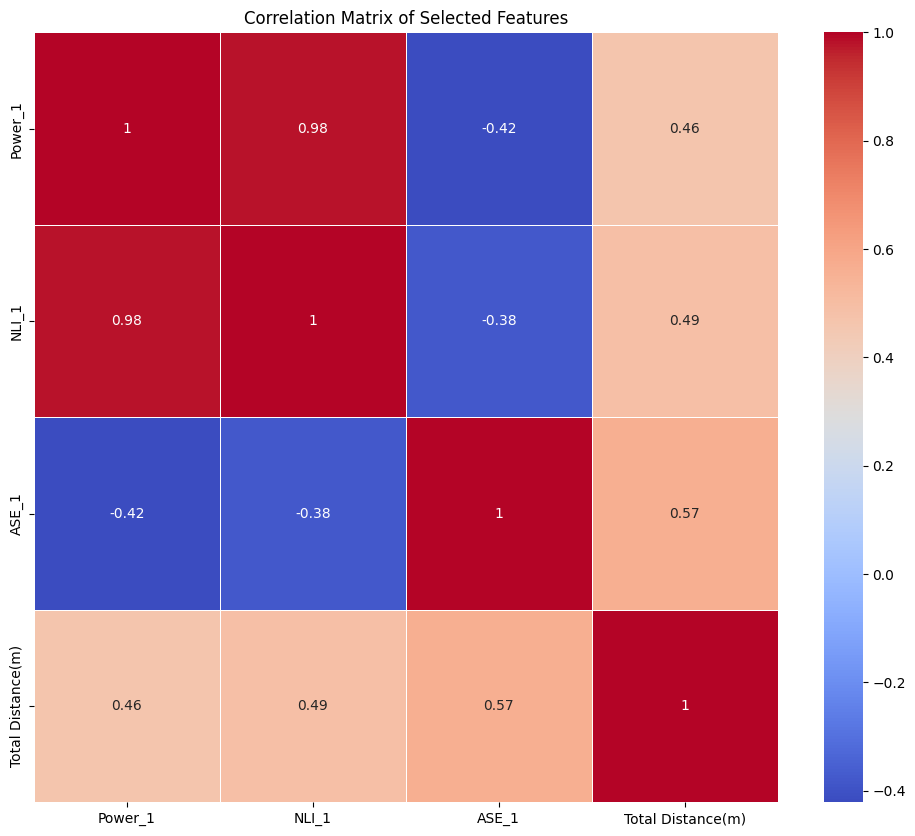

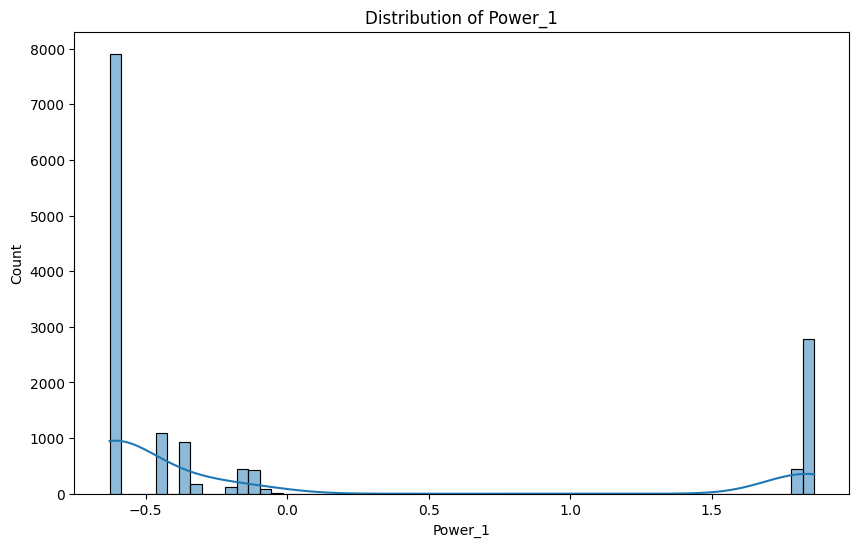

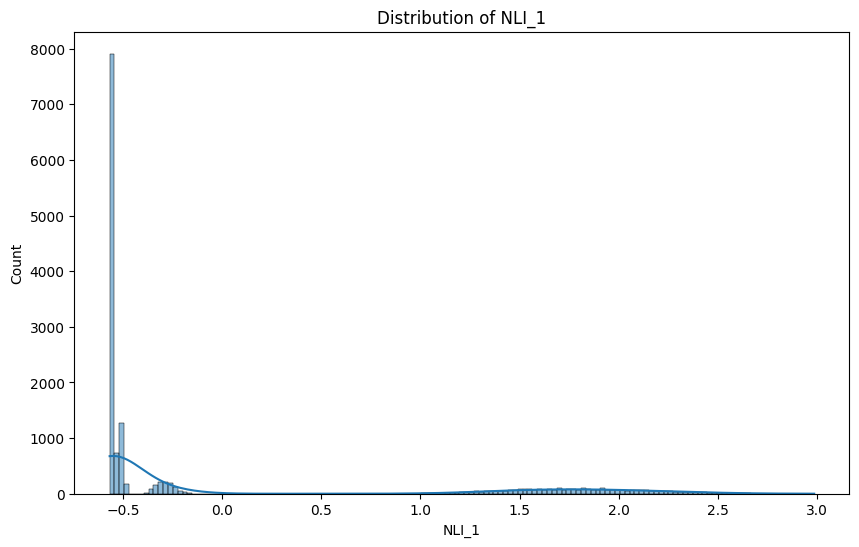

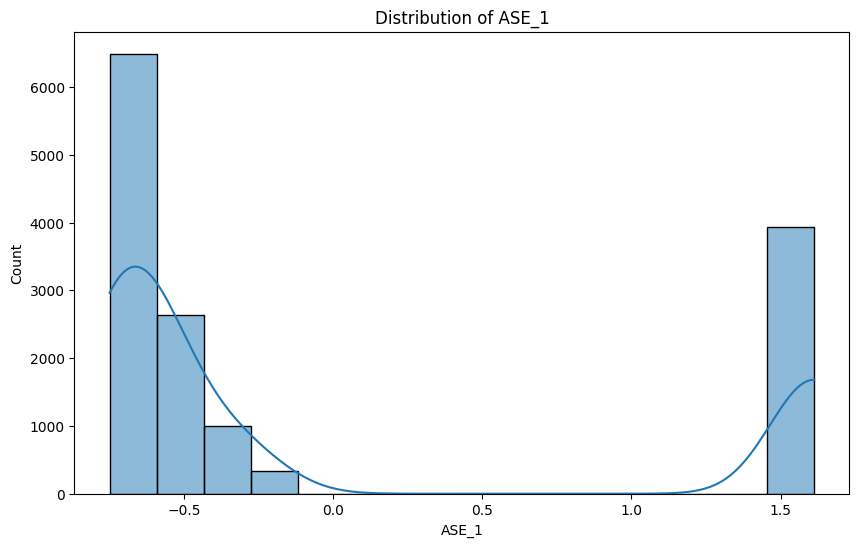

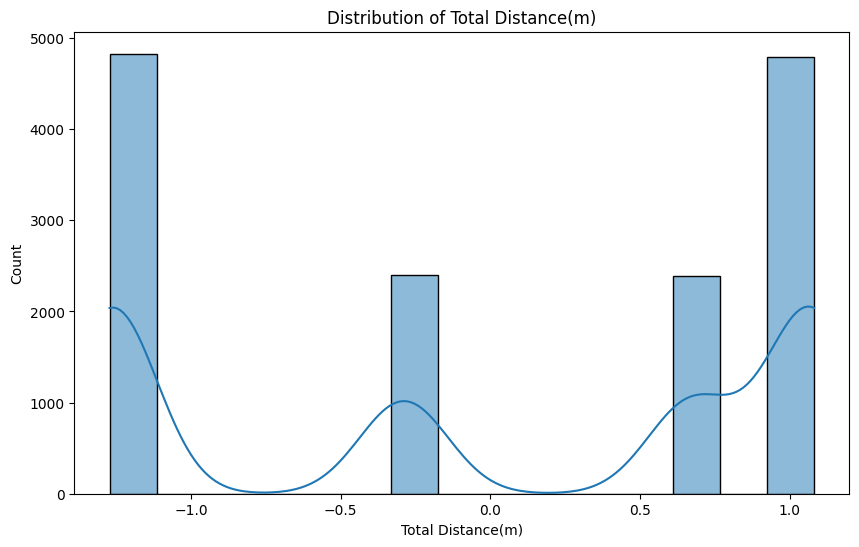

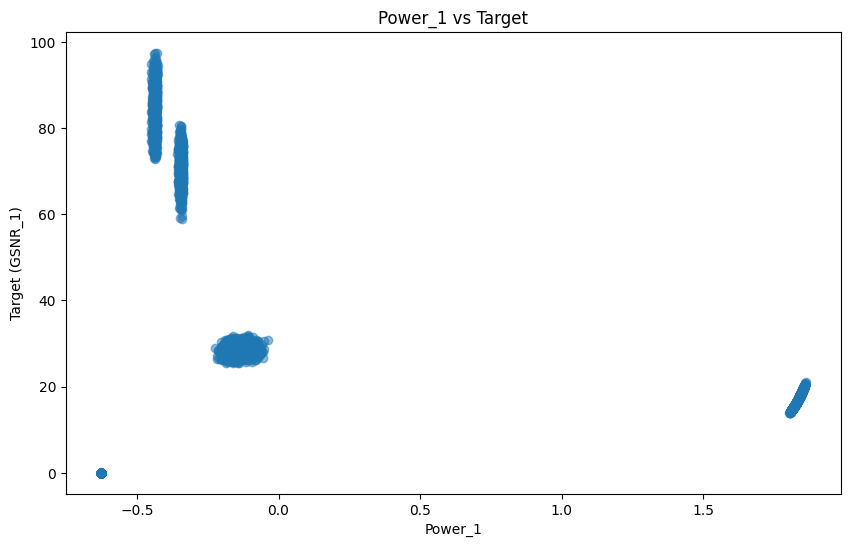

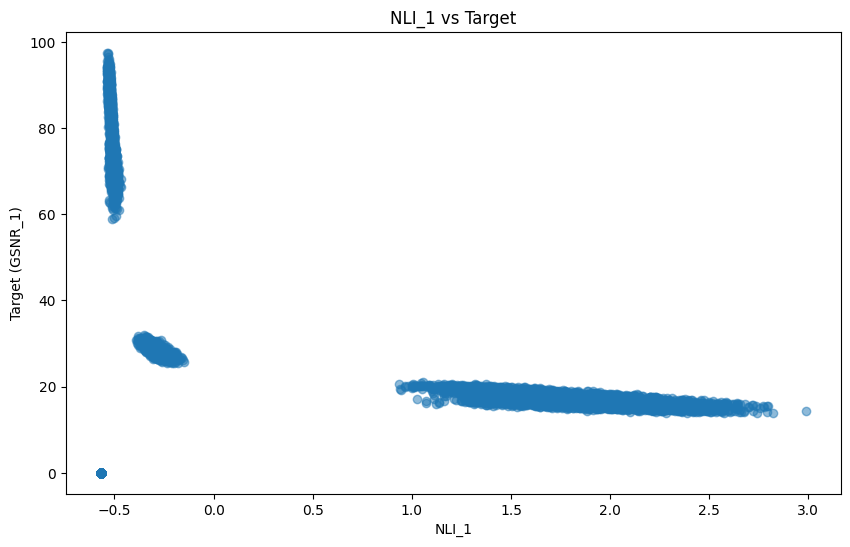

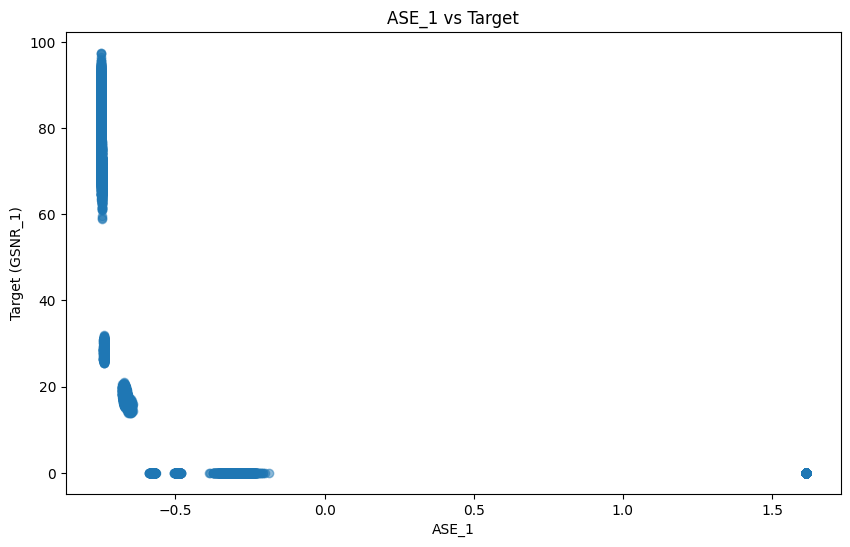

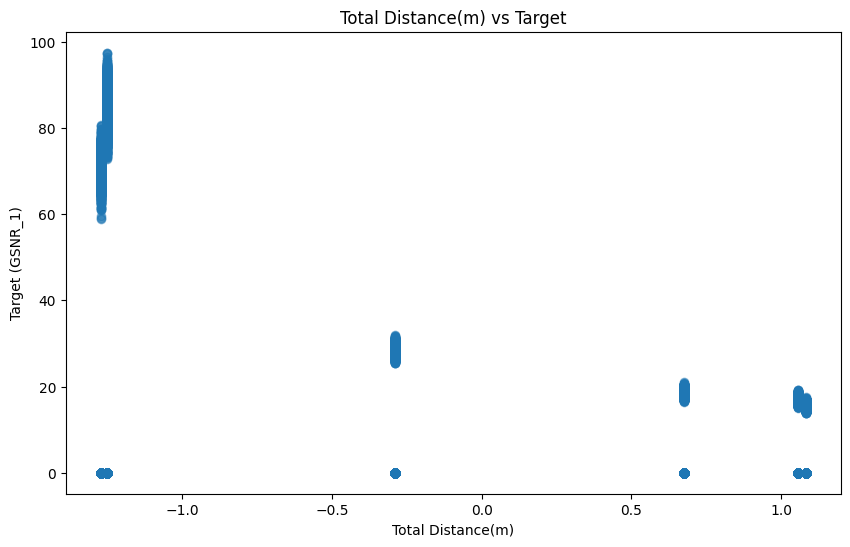

In [9]:
# Install required packages
!pip install seaborn shap lime xgboost

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance
import shap
import lime
import lime.lime_tabular



# Load the data (adjust the path as needed)
filepath = '/content/DataSet_EU_3k_5k.xlsx'  # Update this path
df = pd.read_excel(filepath)

# Display basic information about the dataset
print(df.info())
print(df.head())

# Handle missing values
df.dropna(inplace=True)

# Separate features and target
target = df['GSNR_1']
gsnr_columns = [col for col in df.columns if 'GSNR' in col]
features = df.drop(columns=gsnr_columns)

# Select numerical columns for normalization
numerical_cols = features.select_dtypes(include=[float, int]).columns
features_data = features[numerical_cols].values

# Scale the features
scaler = StandardScaler()
scaled_feature_data = scaler.fit_transform(features_data)
scaled_features_df = pd.DataFrame(scaled_feature_data, columns=numerical_cols)

print("Scaled Features:\n", scaled_features_df.head())
print("Target:\n", target.head())

# Remove frequency columns (as per your original code)
features_columns = [col for col in df.columns if 'frequency' in col]
scaled_features_df = scaled_features_df.drop(columns=features_columns)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(scaled_features_df, target, test_size=0.2, random_state=42)

# Scale the target variable
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

# Feature selection using RandomForest
selector = SelectFromModel(estimator=RandomForestRegressor(n_estimators=100, random_state=42))
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Get selected feature names
selected_features = X_train.columns[selector.get_support()]
print("Selected features:", selected_features)

# Create a new dataframe with selected features
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_features)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_features)

# Visualize correlation matrix of selected features
plt.figure(figsize=(12, 10))
sns.heatmap(X_train_selected_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Selected Features')
plt.show()

# Plot distributions of selected features
for feature in selected_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(X_train_selected_df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

# Plot scatter plots of selected features vs target
for feature in selected_features:
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train_selected_df[feature], y_train, alpha=0.5)
    plt.title(f'{feature} vs Target')
    plt.xlabel(feature)
    plt.ylabel('Target (GSNR_1)')
    plt.show()


Model Performance:
Mean Squared Error: 0.04220387363936973
Mean Absolute Error: 0.06135584349064385
R-squared Score: 0.999940438810046


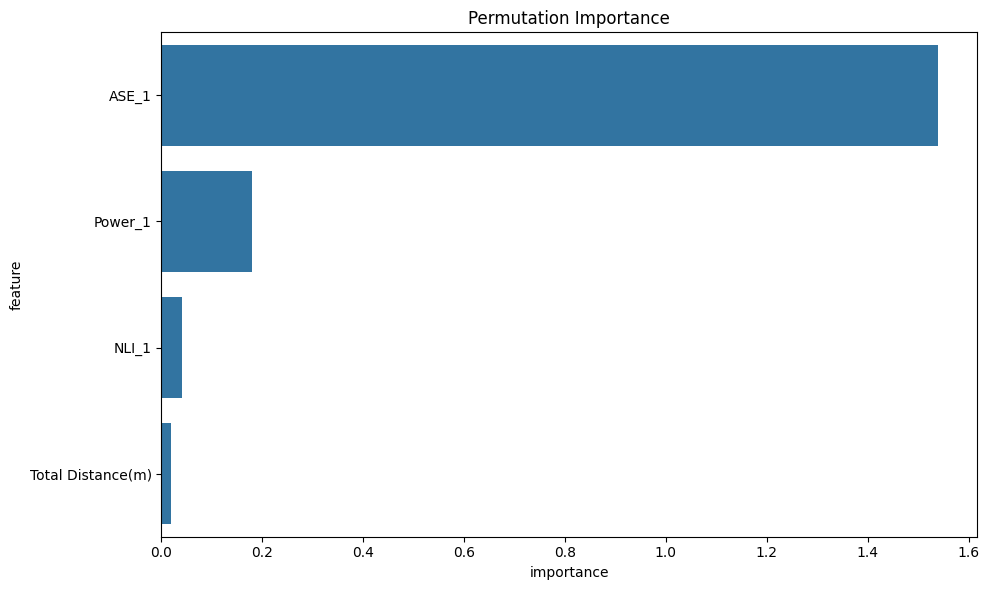

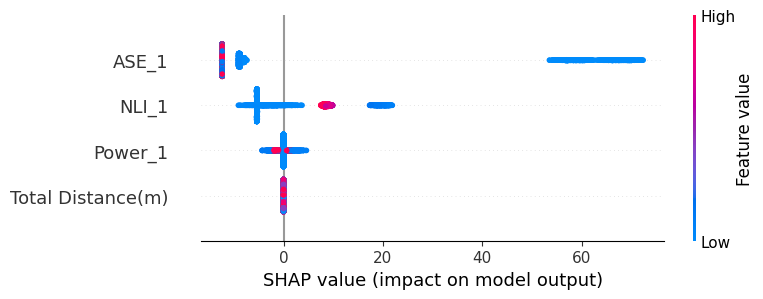

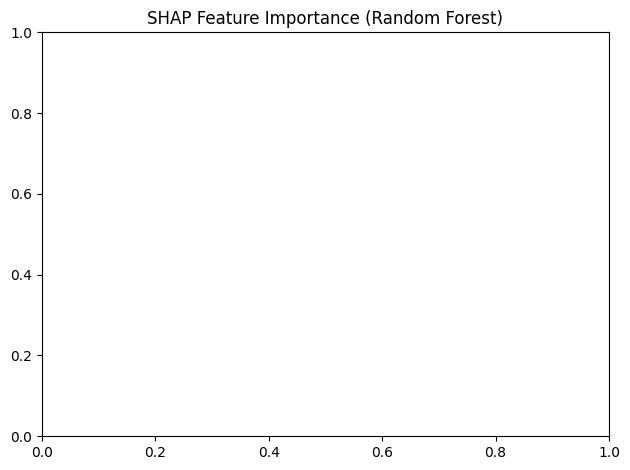

<Figure size 1000x600 with 0 Axes>

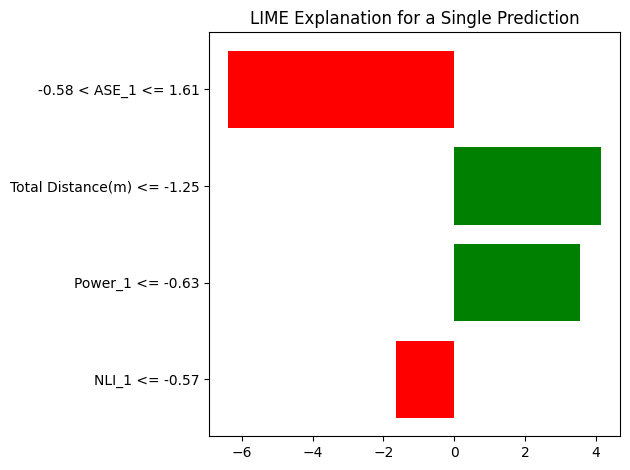

KeyError: 1

<Figure size 1000x600 with 0 Axes>

In [11]:
# (Previous import and data preprocessing steps remain the same)

# Define base models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=300, max_depth=20, min_samples_split=2, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=5, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=7, random_state=42)
}

# Create stacking ensemble
meta_model = Ridge(alpha=1.0)
stacking_model = StackingRegressor(
    estimators=[(name, model) for name, model in models.items()],
    final_estimator=meta_model,
    cv=5
)

# Train the stacking model
stacking_model.fit(X_train_selected, y_train.ravel())

# Make predictions
y_pred = stacking_model.predict(X_test_selected)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance:")
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared Score: {r2}")

# XAI Techniques

# 1. Permutation Importance
perm_importance = permutation_importance(stacking_model, X_test_selected, y_test, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': perm_importance.importances_mean
})
perm_importance_df = perm_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=perm_importance_df)
plt.title('Permutation Importance')
plt.tight_layout()
plt.show()

# 2. SHAP Values (using the first base model - Random Forest)
rf_model = stacking_model.estimators_[0][1]  # Get the Random Forest model
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_selected)

plt.figure()
shap.summary_plot(shap_values, X_test_selected, feature_names=selected_features)
plt.title('SHAP Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

# 3. LIME for a single prediction
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_selected,
    feature_names=selected_features,
    class_names=['GSNR_1'],
    mode='regression'
)

# Explain a single prediction
idx = 0  # Index of the instance to explain
exp = lime_explainer.explain_instance(
    X_test_selected[idx],
    stacking_model.predict,
    num_features=len(selected_features)
)

# Visualize LIME explanation
plt.figure(figsize=(10, 6))
exp.as_pyplot_figure()
plt.title('LIME Explanation for a Single Prediction')
plt.tight_layout()
plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/utils/_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


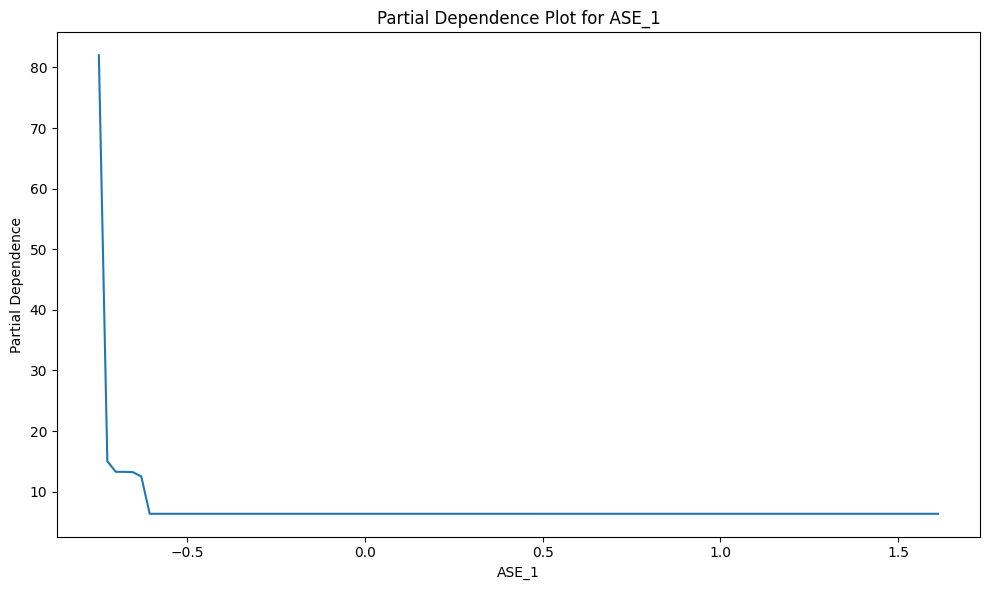

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


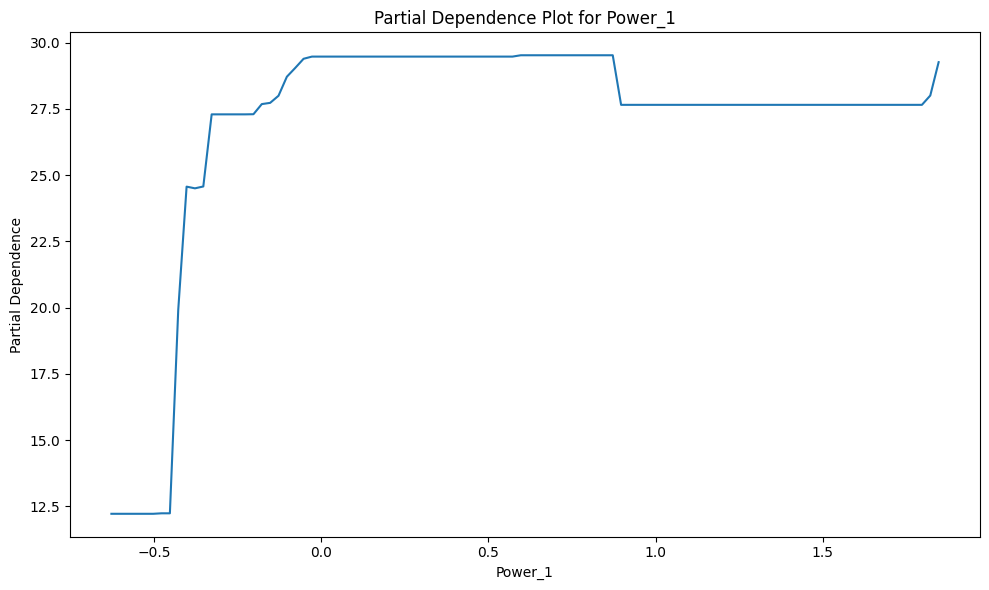

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


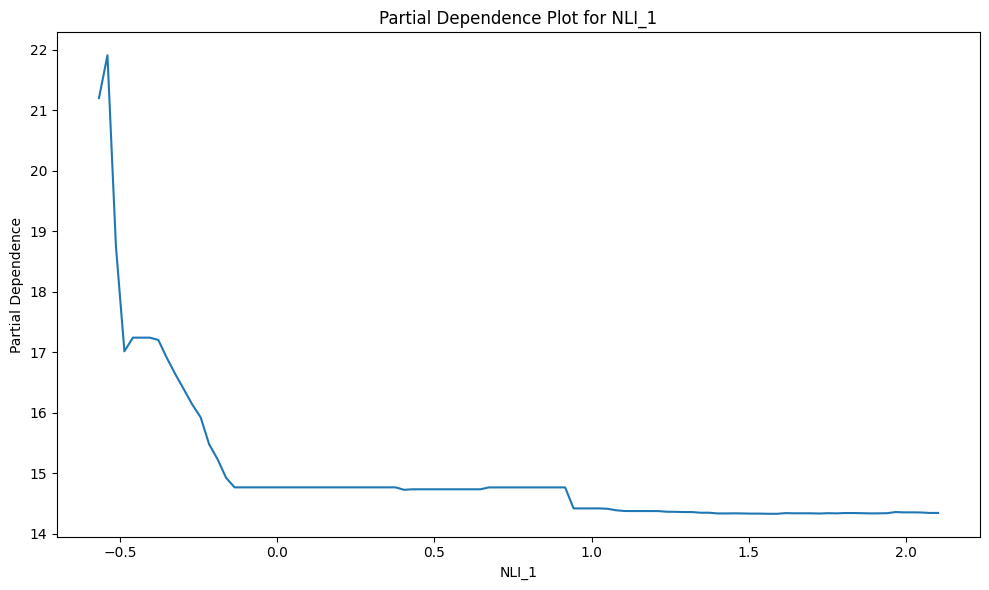

In [13]:
# 4. Partial Dependence Plots
from sklearn.inspection import partial_dependence

# Select top 3 features from permutation importance
top_features = perm_importance_df['feature'].head(3).tolist()

for feature in top_features:
    plt.figure(figsize=(10, 6))
    feature_index = list(selected_features).index(feature)
    pdp_results = partial_dependence(stacking_model, X_train_selected, [feature_index])

    # Extract values and feature values from pdp_results
    pdp_values = pdp_results['average']
    feature_values = pdp_results['values'][0]

    plt.plot(feature_values, pdp_values[0])
    plt.xlabel(feature)
    plt.ylabel('Partial Dependence')
    plt.title(f'Partial Dependence Plot for {feature}')
    plt.tight_layout()
    plt.show()